In [1]:
import os
import torch
from functools import partial
from torch import nn
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython import display
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
import functools
from einops import rearrange, repeat
from scipy.linalg import sqrtm

from scipy.stats import gaussian_kde

from models.mlp import ResNet, CFGResNet, CtrlResNet, CtrlCondResNet
from sdes.forward import uncon_VP_1D
from sdes.backward import uncon_EulerMaruyama, ODE_uncon_EulerMaruyama, EulerMaruyama
from likelihood import get_likelihood_fn

/home/tonyz/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


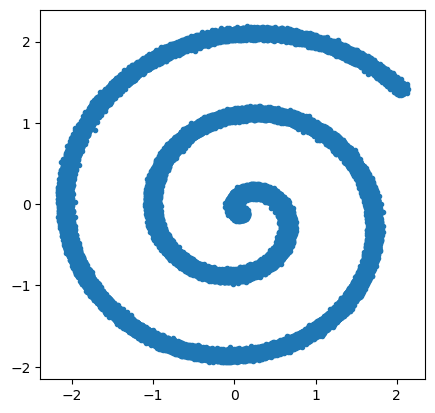

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def data_gen(length):
  t0=5
  k = 1.5
  strength = 0.03
  train_data = torch.zeros((length,2))
  train_param = torch.rand(length)*10-5
  train_data[:, 0]  = 0.2*k*(train_param[:]-t0)*torch.cos(k*(train_param[:]-t0))+strength*torch.randn(length)
  train_data[:, 1]  = 0.2*k*(train_param[:]-t0)*torch.sin(k*(train_param[:]-t0))+strength*torch.randn(length)
  return train_data, train_param

def get_pos_from_rad(rad, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  mu = torch.mean(tmp_arr, dim=0).unsqueeze(0)
  std = torch.std(tmp_arr, dim=0).unsqueeze(0)
  tmp_arr = (tmp_arr - mu) / std
  return tmp_arr.cpu().detach().numpy()

def get_pos_from_single_rad(rad, data_mu, data_std, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  tmp_arr = (tmp_arr - data_mu) / data_std
  return tmp_arr.cpu().detach().numpy()

def swiss_roll_eval(xy_coord, rad, **kwargs):
  data_mu = kwargs.get('data_mu')
  data_std = kwargs.get('data_std')
  if data_mu is None or data_std is None:
    raise ValueError("Both data_mu and data_std must be provided")
  true_xy = get_pos_from_single_rad(rad, data_mu, data_std)
  return torch.tensor(true_xy, device=xy_coord.device) - xy_coord

def loss_fn_vp(model, x, c, beta_min, beta_max, eps=1e-5):
  """The loss function for training score-based generative models VP SDE

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    beta_min: hyperparameter defining noise scales
    beta_max: hyperparameter defining noise scales
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x, device=x.device)
  mu = x*torch.exp(-0.25*random_t**2*(beta_max-beta_min)-0.5*random_t*beta_min)[:, None]
  std = torch.sqrt(1-torch.exp(-0.5*random_t**2*(beta_max-beta_min)-random_t*beta_min))
  perturbed_x = mu + z*std[:, None]
  score = model(perturbed_x, c, random_t)

  loss = torch.mean(torch.sum((score*std[:, None] + z)**2, dim=1))
  #loss = torch.mean(torch.sum((score + z)**2, dim=1))
  return loss

def p_losses(score_model, sde, x0):
    # compute losses (including ELBO, score-matching loss)
    t = torch.rand(x0.shape[0], device=x0.device) * (1. - 1e-5) + 1e-5
    x_perturbed, std, z = sde.forward(x0, t)
    #context_mask = torch.zeros_like(c)
    score_pred = score_model(x_perturbed, t)

    loss_dict = {}

    log_prefix = 'train' 

    # score-mathcing objective function
    score_loss = torch.sum((score_pred*std + z)**2, dim=(1))

    loss_dict.update({f'{log_prefix}/loss_score': score_loss.mean()})

    lamb = sde.g(t)**2
    loss_vlb = lamb*score_loss
    loss_vlb = loss_vlb.mean()
    loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

    loss = score_loss.mean()

    loss_dict.update({f'{log_prefix}/loss': loss})

    return loss, loss_dict

def p_losses_cond(score_model, sde, x0, c, **kwargs):
    # compute losses (including ELBO, score-matching loss)
    t = torch.rand(x0.shape[0], device=x0.device) * (1. - 1e-5) + 1e-5
    x_perturbed, std, z = sde.forward(x0, t)
    #context_mask = torch.zeros_like(c)
    score_pred = score_model(x_perturbed, c, t, **kwargs)

    loss_dict = {}

    log_prefix = 'train' 

    # score-mathcing objective function
    score_loss = torch.sum((score_pred*std + z)**2, dim=(1))

    loss_dict.update({f'{log_prefix}/loss_score': score_loss.mean()})

    lamb = sde.g(t)**2
    loss_vlb = lamb*score_loss
    loss_vlb = loss_vlb.mean()
    loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

    loss = score_loss.mean()

    loss_dict.update({f'{log_prefix}/loss': loss})

    return loss, loss_dict

# calculate frechet inception distance
def fid_metric(act1, act2):
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  if np.isnan(sigma1).any() or np.isnan(sigma2).any() or np.isinf(sigma1).any() or np.isinf(sigma2).any():
    print("Invalid values detected in sigma1 or sigma2. Returning NaN for metrics.")
    return (np.nan, np.nan)
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

def get_KLD(samp1=None, dat=None):
    # Load the data
    if samp1 is None and dat is None:
        samp1 = np.loadtxt('samples.out')
        dat = np.loadtxt('true_dat.out')

    # Parameters for the histogram
    bins = np.arange(-4, 4 + 0.16, 0.16)
    hist_range = [[-3, 3], [-3, 3]]
    histogram1, xedges, yedges = np.histogram2d(samp1[:, 0], samp1[:, 1], bins=[bins, bins], range=hist_range, density=True)
    # Calculate the entropy for samp1
    entropy_samp1 = -np.sum(histogram1 * np.log(histogram1 + 1.e-20)) * 0.16 * 0.16

    histogram2, _, _ = np.histogram2d(dat[:, 0], dat[:, 1], bins=[bins, bins], range=hist_range, density=True)
    # Calculate the entropy for true data
    entropy_dat = -np.sum(histogram2 * np.log(histogram2 + 1.e-20)) * 0.16 * 0.16

    # Flatten the histograms for KLD calculation
    flat_pdf_true = histogram2.flatten() + 1.e-20
    flat_pdf_gen = histogram1.flatten() + 1.e-20

    # Calculate the KLD
    KLD = np.sum(flat_pdf_true * np.log(flat_pdf_true / flat_pdf_gen)) * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
    print('KLD: ', KLD)
    #plot_distribution(xedges, yedges, histogram1, histogram2, hist_range)
    return KLD, entropy_samp1, entropy_dat

seed_everything(0)
data_type = 'swiss_roll' # 'circle'
#ndim = 2

train_data_length = int(1E6)

xlim_min = -1.5
xlim_max = 2.0
ylim_min = -1.5
ylim_max = 2.0

train_data, _ = data_gen(train_data_length)
data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
data_std = torch.std(train_data, dim=0).unsqueeze(0)
train_data = (train_data - data_mu) / data_std
#train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
generator = torch.Generator().manual_seed(0)
train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)
#val_loader = torch.utils.data.DataLoader(
#    val_set, batch_size=batch_size, shuffle=True
#)

plt.plot(train_data[train_set.indices, 0], train_data[train_set.indices, 1], ".")
#plt.plot(train_data[val_set.indices, 0], train_data[val_set.indices, 1], ".")
#plt.xlim(xlim_min, xlim_max)
#plt.ylim(ylim_min, ylim_max)
plt.gca().set_aspect('equal', adjustable='box')

In [3]:
print(train_data.shape)
#np.savetxt('true_dat.out', train_data)

torch.Size([1000000, 2])


No saved model weights found or Training=True.
training ...
train data length:  128  last_loss:  0.3787640817463398


Sampling: 100%|██████████| 1000/1000 [04:09<00:00,  4.01iteration/s]


KLD:  1.0123096416967905
Train data size: 128


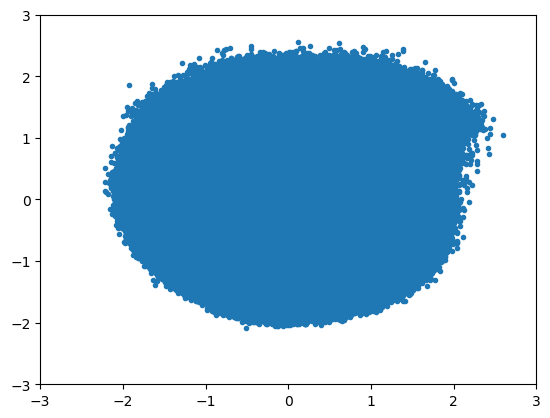

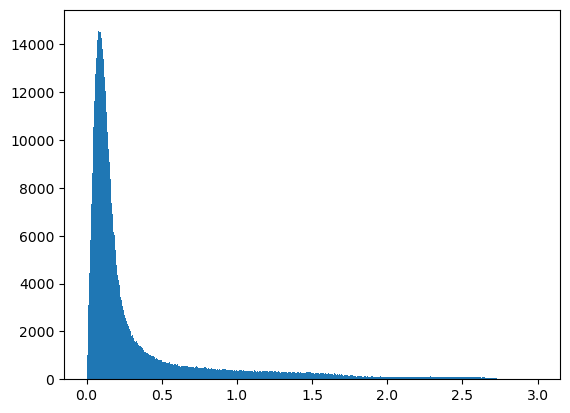

0.34538057
No saved model weights found or Training=True.
training ...
train data length:  256  last_loss:  0.3342599477618933


Sampling: 100%|██████████| 1000/1000 [04:05<00:00,  4.08iteration/s]


KLD:  0.692534621366608
Train data size: 256


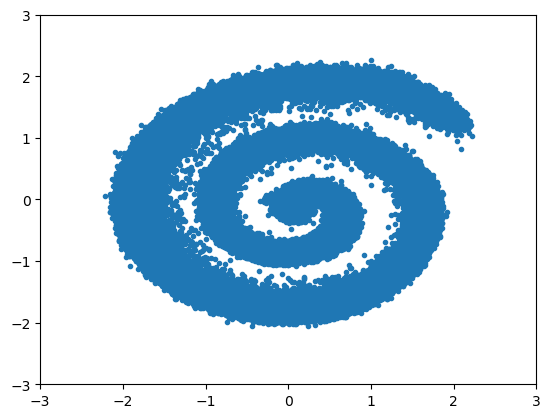

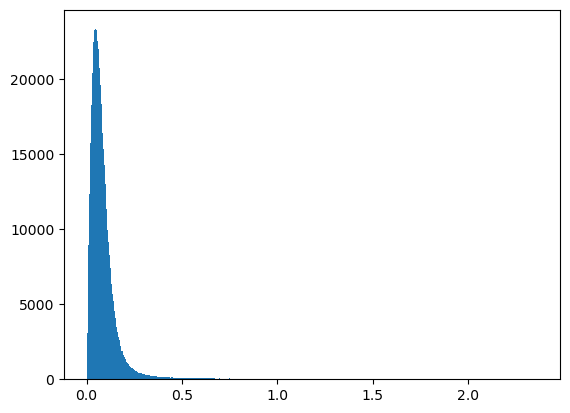

0.08852584
No saved model weights found or Training=True.
training ...
train data length:  512  last_loss:  0.2634918997064233


Sampling: 100%|██████████| 1000/1000 [04:04<00:00,  4.09iteration/s]


KLD:  0.2009148228033409
Train data size: 512


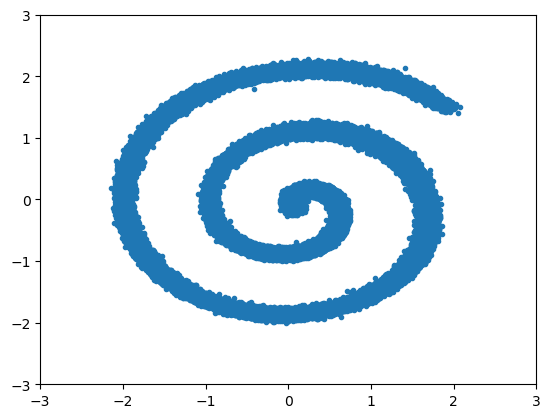

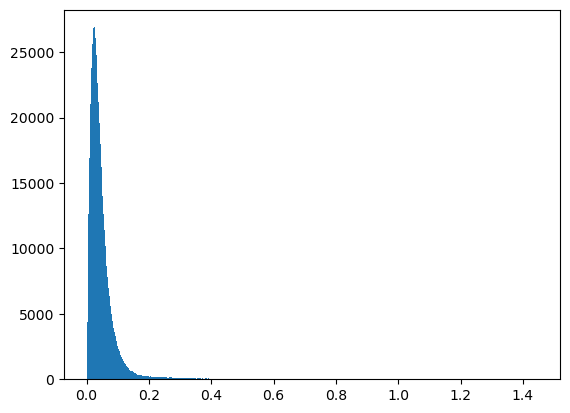

0.050055023
No saved model weights found or Training=True.
training ...
train data length:  1024  last_loss:  0.20971629302948713


Sampling: 100%|██████████| 1000/1000 [03:56<00:00,  4.24iteration/s]


KLD:  0.14391301255638167
Train data size: 1024


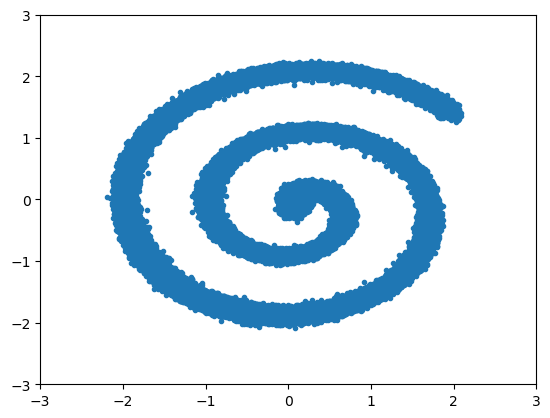

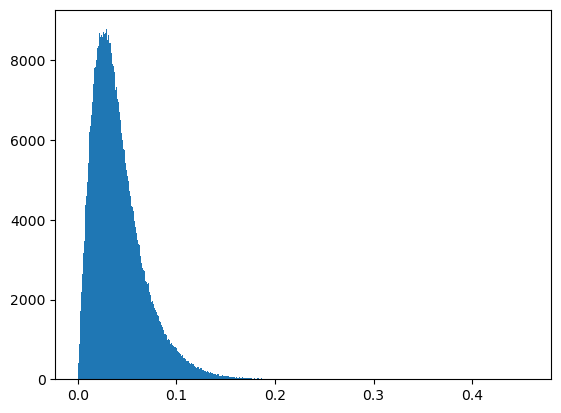

0.041335844
No saved model weights found or Training=True.
training ...
train data length:  2048  last_loss:  0.2077099364832975


Sampling: 100%|██████████| 1000/1000 [04:06<00:00,  4.06iteration/s]


KLD:  0.08625538292899834
Train data size: 2048


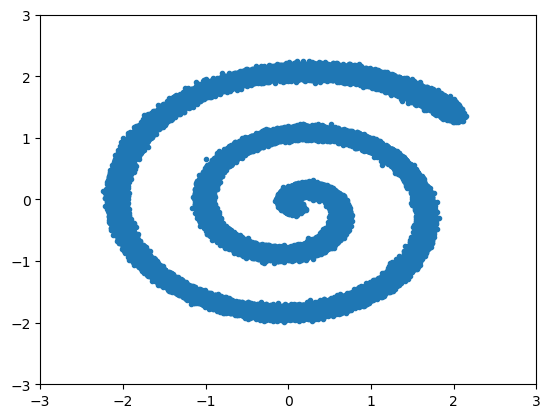

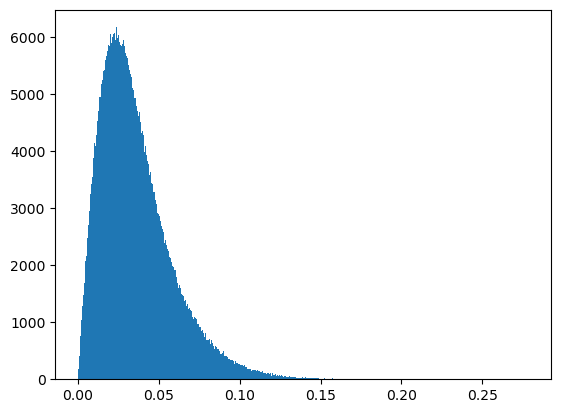

0.036083926
No saved model weights found or Training=True.
training ...
train data length:  4096  last_loss:  0.19373824298963882


Sampling: 100%|██████████| 1000/1000 [04:08<00:00,  4.02iteration/s]


KLD:  0.1078816767597964
Train data size: 4096


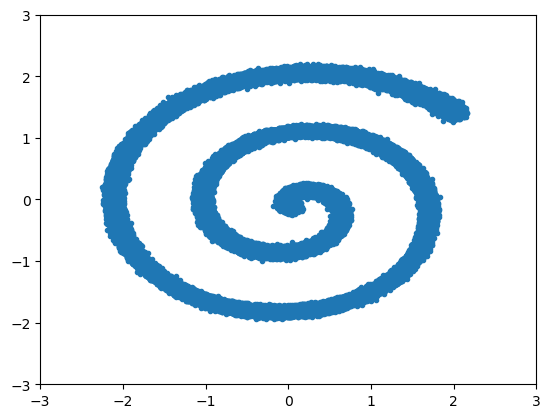

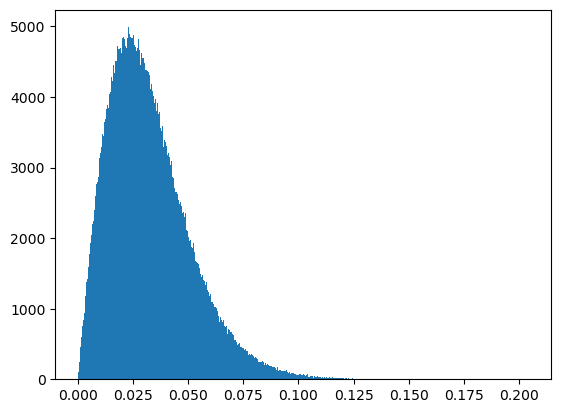

0.032515313
No saved model weights found or Training=True.
training ...
train data length:  8192  last_loss:  0.17135787990991957


Sampling: 100%|██████████| 1000/1000 [03:57<00:00,  4.22iteration/s]


KLD:  0.020538154924949936
Train data size: 8192


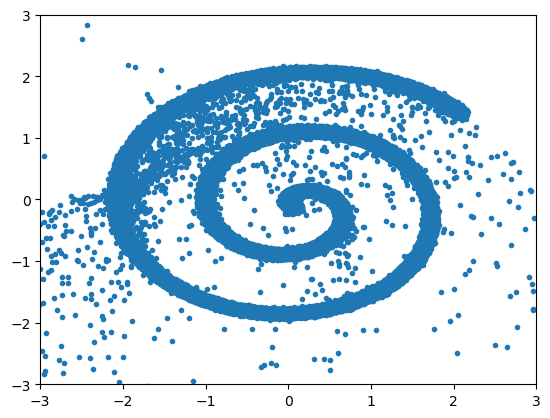

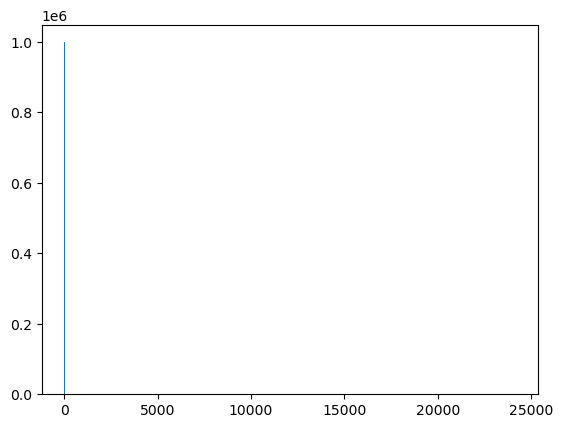

0.6862528


In [4]:
seed_everything(0)
# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 0.5 # for SDE noise [VP]
cond_scale =1
rescaled_phi = 0

device='cuda'
train_len_vals = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
sample_size = int(1E6)
orig_sample, orig_labels = data_gen(sample_size)
data_mu = torch.mean(orig_sample, dim=0).unsqueeze(0)
data_std = torch.std(orig_sample, dim=0).unsqueeze(0)
orig_sample = (orig_sample - data_mu) / data_std
last_loss_values = []
fid_values = []
avg_nll_values = []
KLD_arr = []
H_gen_arr = []
H_true_arr = []

Training =True

for train_data_length in train_len_vals:
    seed_everything(0)
    train_data, train_labels = data_gen(train_data_length)
    data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
    data_std = torch.std(train_data, dim=0).unsqueeze(0)
    train_data = (train_data - data_mu) / data_std
    #train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
    train_set = [
        (train_data[i], train_labels[i]) for i in range(train_data_length)
    ]
    generator = torch.Generator().manual_seed(0)
    train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size
    )

    vp = uncon_VP_1D(beta_min, beta_max)

    model = CFGResNet(2, 2, cond_size=1, model_channels=128,
                    channel_mult=[1,1,1,1,1,1], channel_mult_emb=1, num_blocks=2,
                    dropout=0, emb_type="sinusoidal", channel_mult_time=1, 
                    channel_mult_cond=1, cond_drop_prob=0)

    file_path = f'mdl_weights/uncon_train_len_{train_data_length}.pth'

    if os.path.exists(file_path) and not Training:
        model.load_state_dict(torch.load(file_path))
        print("Model weights loaded successfully, computing last epoch loss.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c)
                
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                num_items += x.shape[0]
                avg_loss += loss.item() * x.shape[0]
    else:
        print("No saved model weights found or Training=True.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
                loss_v.append(loss.item())
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            #if epoch % output_step == 0 or epoch == num_epochs - 1:
        torch.save(model.state_dict(), 'mdl_weights/uncon_train_len'+'_'+str(train_data_length)+'.pth')
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

    model.eval()
    last_loss = avg_loss / num_items
    vp_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
    #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
    test_cond = torch.rand(sample_size, device=device)*10-5
    with torch.no_grad():
        samples, _ = vp_sampler(model, vp, (sample_size, 2),  device, c=test_cond,
                                 cond_scale=cond_scale, rescaled_phi=rescaled_phi, cond_drop_prob=0)
    #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
    samples = samples.detach().cpu().numpy()
    fid = fid_metric(samples, orig_sample.detach().cpu().numpy())
    inverse_scaler = 1 # dummy param
    #likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
    #nll = likelihood_fn(model, orig_sample.to(device))[0]
    #avg_nll = np.mean(nll.detach().cpu().numpy())
    '''
    nll_total = 0
    process_batch_size = 100000
    for i in range(0, orig_sample.size(0), process_batch_size):
        batch = orig_sample[i:i + process_batch_size].to(device)  
        batch_nll = likelihood_fn(model, batch)[0]  
        nll_total += batch_nll.sum().item()  
    # Calculate the average NLL
    avg_nll = nll_total / orig_sample.size(0)
    '''
    
    last_loss_values.append(last_loss)
    fid_values.append(fid)
    #avg_nll_values.append(avg_nll)
    kld, H_gen, H_true = get_KLD(samp1=samples, dat=orig_sample.detach().cpu().numpy())
    KLD_arr.append(kld)
    H_gen_arr.append(H_gen)
    H_true_arr.append(H_true)

    print('Train data size:', train_data_length)
    plt.plot(samples[:,0], samples[:,1], ".")
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.show()
    true_pos = get_pos_from_rad(test_cond)
    avg_err = np.mean(np.abs(samples-true_pos), axis=1)
    plt.hist(avg_err, bins=1000)
    plt.show()
    print(np.mean(avg_err))

In [5]:
import pandas as pd

results_df = pd.DataFrame({
    'data_len': train_len_vals,
    'beta_max': np.repeat(beta_max, len(train_len_vals)),
    'last_loss': last_loss_values[-len(train_len_vals):],
    'fid': fid_values[-len(train_len_vals):],
    #'avg_nll': avg_nll_values[-len(train_len_vals):],
    'KLD': KLD_arr[-len(train_len_vals):],
    'H Gen': H_gen_arr[-len(train_len_vals):],
    'H True': H_true_arr[-len(train_len_vals):]
})

print(results_df)

   data_len  beta_max  last_loss          fid       KLD     H Gen    H True
0       128       0.5   0.378764     0.045906  1.012310  1.839852  1.218089
1       256       0.5   0.334260     0.006664  0.692535  1.469447  1.218089
2       512       0.5   0.263492     0.002924  0.200915  1.235970  1.218089
3      1024       0.5   0.209716     0.001346  0.143913  1.329808  1.218089
4      2048       0.5   0.207710     0.000566  0.086255  1.300634  1.218089
5      4096       0.5   0.193738     0.000705  0.107882  1.278248  1.218089
6      8192       0.5   0.171358  6228.168276  0.020538  1.232194  1.218089


No saved model weights found or Training=True.
training ...
train data length:  128  last_loss:  1.4882565140724182
training ...
train data length:  128  last_loss:  0.9758072197437286


Sampling: 100%|██████████| 1000/1000 [05:53<00:00,  2.83iteration/s]


KLD:  1.3276546637115545
Train data size: 128


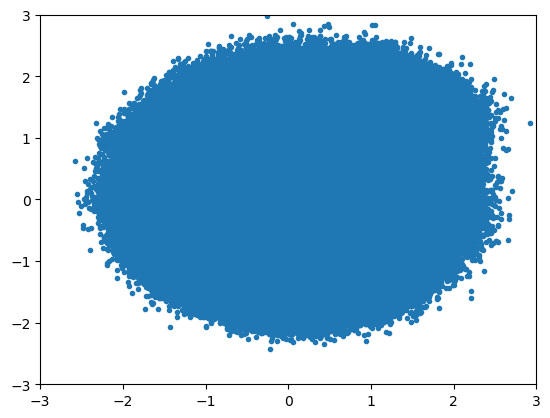

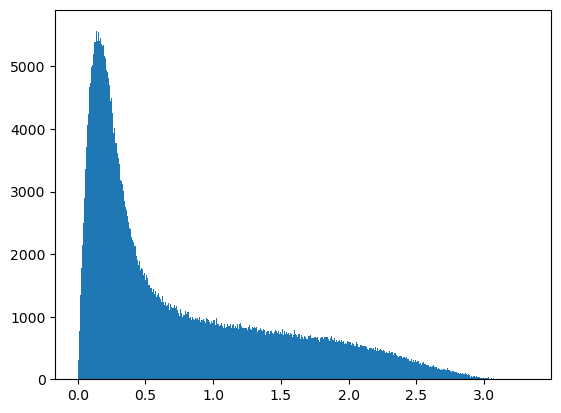

0.7739692
No saved model weights found or Training=True.
training ...
train data length:  256  last_loss:  1.5307895839214325
training ...
train data length:  256  last_loss:  0.6665189526975155


Sampling: 100%|██████████| 1000/1000 [05:37<00:00,  2.96iteration/s]


KLD:  0.6963890134704513
Train data size: 256


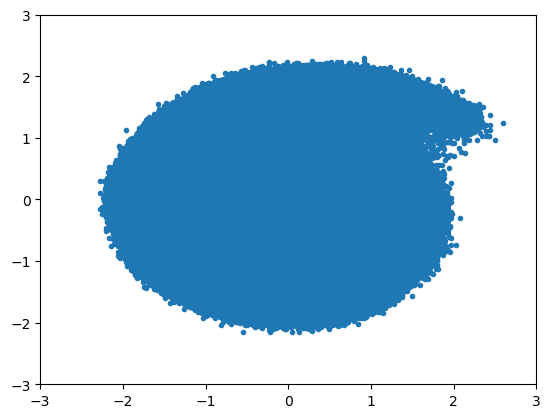

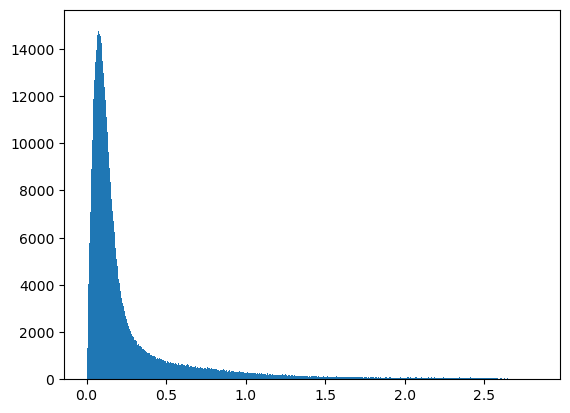

0.27700102
No saved model weights found or Training=True.
training ...
train data length:  512  last_loss:  1.4990349560976028
training ...
train data length:  512  last_loss:  0.22735121008008718


Sampling: 100%|██████████| 1000/1000 [05:41<00:00,  2.93iteration/s]


KLD:  0.3350594013102456
Train data size: 512


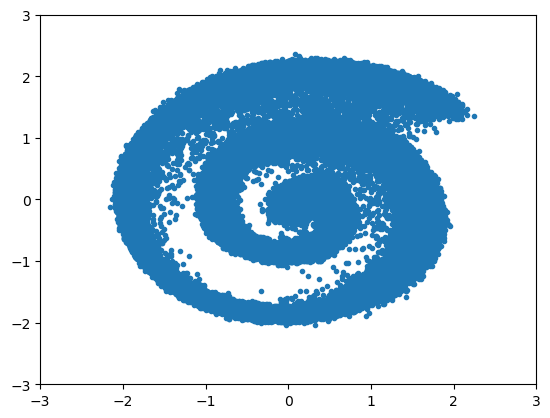

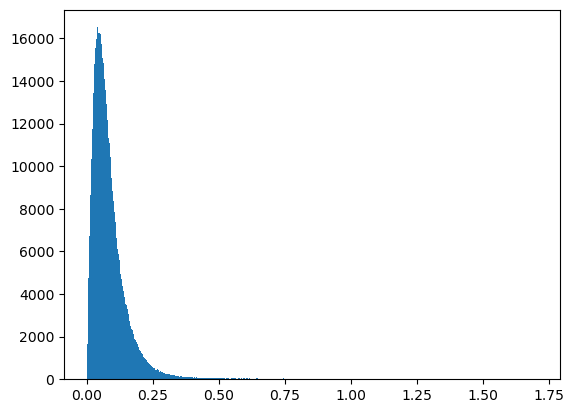

0.09018271
No saved model weights found or Training=True.
training ...
train data length:  1024  last_loss:  1.4182218313217163
training ...
train data length:  1024  last_loss:  0.27437628293409944


Sampling: 100%|██████████| 1000/1000 [05:13<00:00,  3.19iteration/s]


KLD:  0.14092248098315074
Train data size: 1024


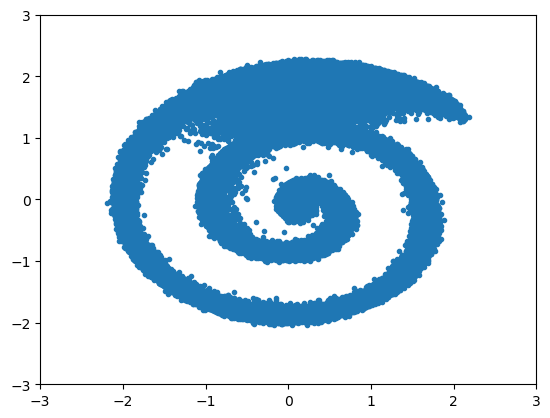

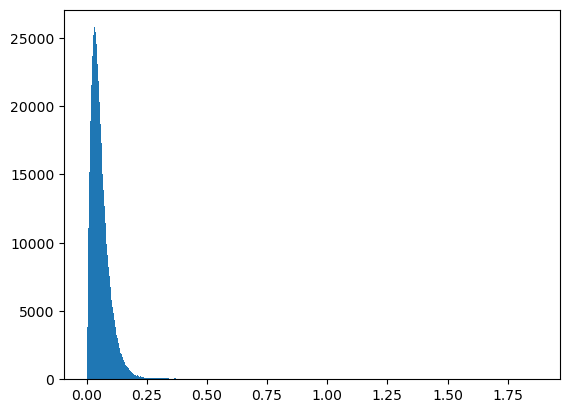

0.06465058
No saved model weights found or Training=True.
training ...
train data length:  2048  last_loss:  1.400127599015832
training ...
train data length:  2048  last_loss:  0.19429636397399008


Sampling: 100%|██████████| 1000/1000 [05:16<00:00,  3.16iteration/s]


KLD:  0.08367439187224757
Train data size: 2048


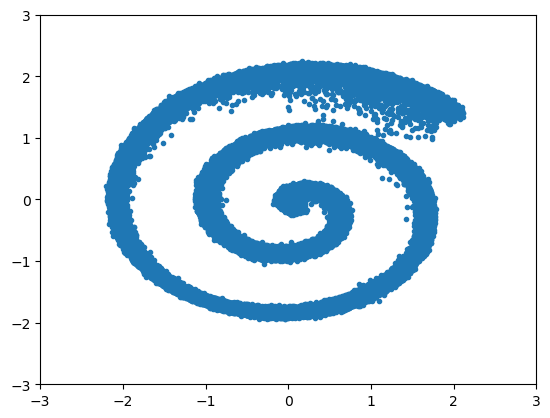

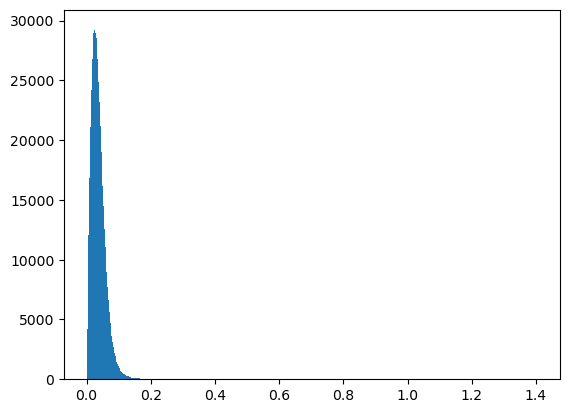

0.038663883
No saved model weights found or Training=True.
training ...
train data length:  4096  last_loss:  1.3929547253064811
training ...
train data length:  4096  last_loss:  0.17518440674757585


Sampling: 100%|██████████| 1000/1000 [05:15<00:00,  3.17iteration/s]


KLD:  0.08224216242052268
Train data size: 4096


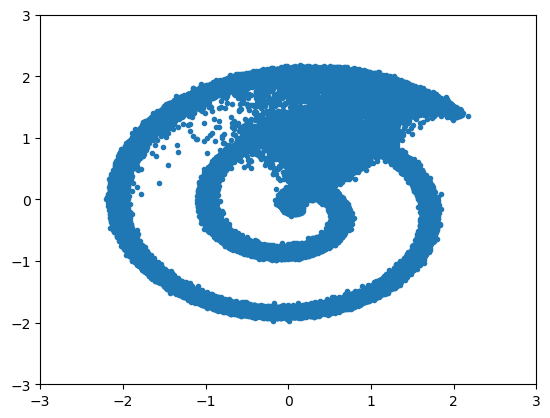

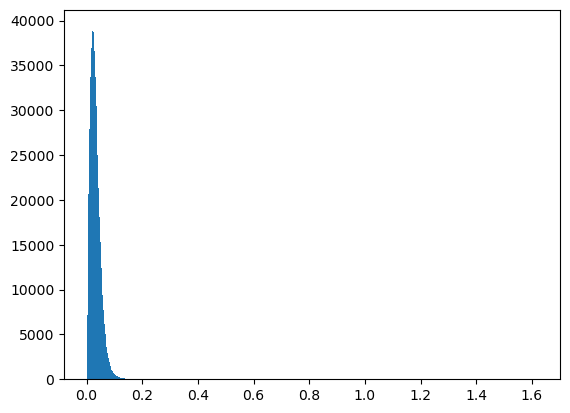

0.045089953
No saved model weights found or Training=True.
training ...
train data length:  8192  last_loss:  1.3859022466931492
training ...
train data length:  8192  last_loss:  0.18632002422964433


Sampling: 100%|██████████| 1000/1000 [05:42<00:00,  2.92iteration/s]


KLD:  0.01368113958690929
Train data size: 8192


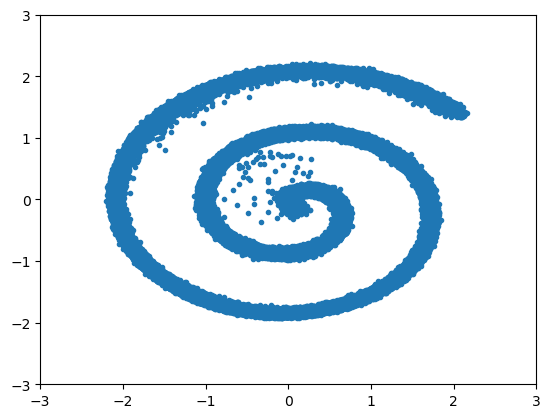

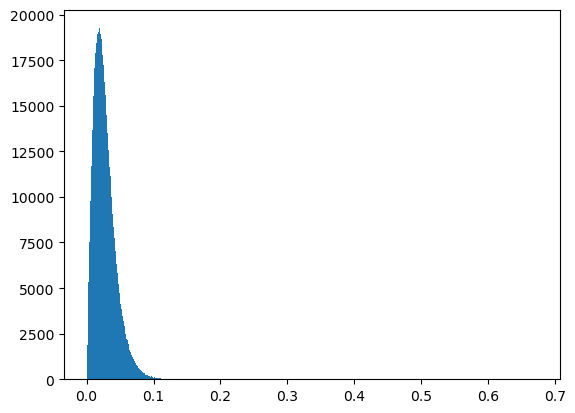

0.027064372


In [4]:
seed_everything(0)
# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 0.5 # for SDE noise [VP]
cond_scale =1
rescaled_phi = 0

device='cuda'
train_len_vals = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
sample_size = int(1E6)
orig_sample, orig_labels = data_gen(sample_size)
data_mu = torch.mean(orig_sample, dim=0).unsqueeze(0)
data_std = torch.std(orig_sample, dim=0).unsqueeze(0)
orig_sample = (orig_sample - data_mu) / data_std
last_loss_values = []
fid_values = []
avg_nll_values = []
KLD_arr = []
H_gen_arr = []
H_true_arr = []

Training =True

for train_data_length in train_len_vals:
    seed_everything(0)
    train_data, train_labels = data_gen(train_data_length)
    data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
    data_std = torch.std(train_data, dim=0).unsqueeze(0)
    train_data = (train_data - data_mu) / data_std
    #train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
    train_set = [
        (train_data[i], train_labels[i]) for i in range(train_data_length)
    ]
    generator = torch.Generator().manual_seed(0)
    train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size
    )

    vp = uncon_VP_1D(beta_min, beta_max)

    model = CtrlResNet(2, 2, 1, conv_channels=128, model_channels=128, channel_mult=[1,1,1,1,1,1], 
                    channel_mult_emb=1, num_blocks=2, dropout=0, 
                    emb_type="sinusoidal", channel_mult_time=1, 
                    channel_mult_cond=1)

    file_path = f'mdl_weights/ctrl_train_len_{train_data_length}.pth'

    if os.path.exists(file_path) and not Training:
        model.load_state_dict(torch.load(file_path))
        print("Model weights loaded successfully, computing last epoch loss.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c)
                
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                num_items += x.shape[0]
                avg_loss += loss.item() * x.shape[0]
    else:
        print("No saved model weights found or Training=True.")
        # for training of the uncon model, lock the control net
        for name, param in model.named_parameters():
            if 'ctrl' in name:
                param.requires_grad = False

        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c, controlnet=False)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

        # for training of the control net, lock the uncon model
        for name, param in model.named_parameters():
            if 'ctrl' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c, controlnet=True)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
                loss_v.append(loss.item())
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            #if epoch % output_step == 0 or epoch == num_epochs - 1:
        torch.save(model.state_dict(), 'mdl_weights/ctrl_train_len'+'_'+str(train_data_length)+'.pth')
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

    model.eval()
    last_loss = avg_loss / num_items
    vp_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
    #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
    test_cond = torch.rand(sample_size, device=device)*10-5
    with torch.no_grad():
        samples, _ = vp_sampler(model, vp, (sample_size, 2),  device, c=test_cond,
                                controlnet=True)
    #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
    samples = samples.detach().cpu().numpy()
    fid = fid_metric(samples, orig_sample.detach().cpu().numpy())
    inverse_scaler = 1 # dummy param
    #likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
    #nll = likelihood_fn(model, orig_sample.to(device))[0]
    #avg_nll = np.mean(nll.detach().cpu().numpy())
    '''
    nll_total = 0
    process_batch_size = 100000
    for i in range(0, orig_sample.size(0), process_batch_size):
        batch = orig_sample[i:i + process_batch_size].to(device)  
        batch_nll = likelihood_fn(model, batch)[0]  
        nll_total += batch_nll.sum().item()  
    # Calculate the average NLL
    avg_nll = nll_total / orig_sample.size(0)
    '''
    
    last_loss_values.append(last_loss)
    fid_values.append(fid)
    #avg_nll_values.append(avg_nll)
    kld, H_gen, H_true = get_KLD(samp1=samples, dat=orig_sample.detach().cpu().numpy())
    KLD_arr.append(kld)
    H_gen_arr.append(H_gen)
    H_true_arr.append(H_true)

    print('Train data size:', train_data_length)
    plt.plot(samples[:,0], samples[:,1], ".")
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.show()
    true_pos = get_pos_from_rad(test_cond)
    avg_err = np.mean(np.abs(samples-true_pos), axis=1)
    plt.hist(avg_err, bins=1000)
    plt.show()
    print(np.mean(avg_err))

In [5]:
import pandas as pd

results_df = pd.DataFrame({
    'data_len': train_len_vals,
    'beta_max': np.repeat(beta_max, len(train_len_vals)),
    'last_loss': last_loss_values[-len(train_len_vals):],
    'fid': fid_values[-len(train_len_vals):],
    #'avg_nll': avg_nll_values[-len(train_len_vals):],
    'KLD': KLD_arr[-len(train_len_vals):],
    'H Gen': H_gen_arr[-len(train_len_vals):],
    'H True': H_true_arr[-len(train_len_vals):]
})

print(results_df)

   data_len  beta_max  last_loss       fid       KLD     H Gen    H True
0       128       0.5   0.975807  0.036707  1.327655  2.427375  1.218089
1       256       0.5   0.666519  0.033103  0.696389  1.945828  1.218089
2       512       0.5   0.227351  0.004292  0.335059  1.484958  1.218089
3      1024       0.5   0.274376  0.002289  0.140922  1.385321  1.218089
4      2048       0.5   0.194296  0.001004  0.083674  1.282991  1.218089
5      4096       0.5   0.175184  0.001863  0.082242  1.286187  1.218089
6      8192       0.5   0.186320  0.000079  0.013681  1.226156  1.218089


No saved model weights found or Training=True.
training ...
train data length:  128  last_loss:  0.39102377742528915
training ...
train data length:  128  last_loss:  0.41190681606531143


Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.64iteration/s]


KLD:  0.9633636720593473
Train data size: 128


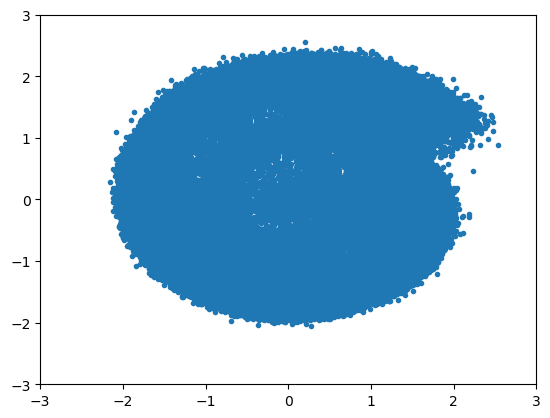

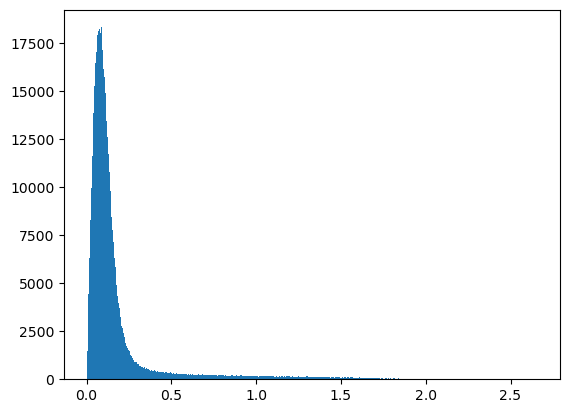

0.18505488
No saved model weights found or Training=True.
training ...
train data length:  256  last_loss:  0.36225474067032337
training ...
train data length:  256  last_loss:  0.28036805149167776


Sampling: 100%|██████████| 1000/1000 [06:14<00:00,  2.67iteration/s]


KLD:  0.7299365338973265
Train data size: 256


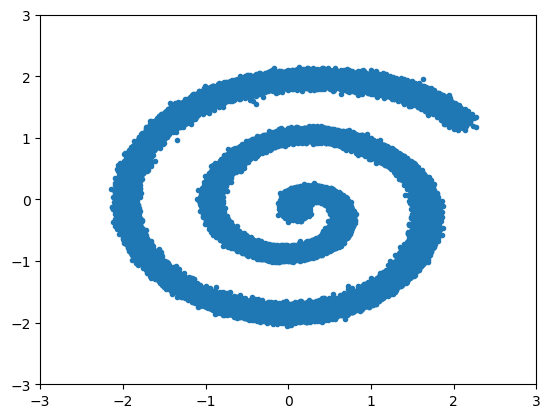

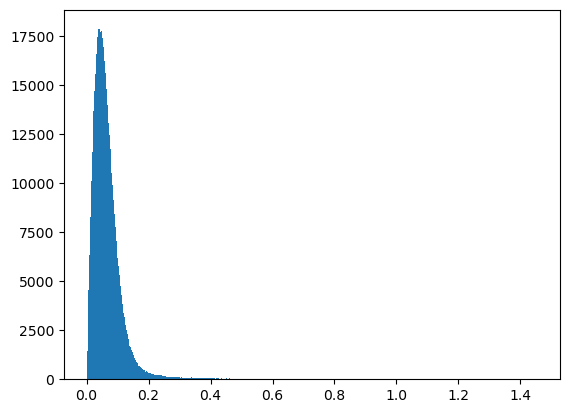

0.06746028
No saved model weights found or Training=True.
training ...
train data length:  512  last_loss:  0.2516241827979684
training ...
train data length:  512  last_loss:  0.14818137465044856


Sampling: 100%|██████████| 1000/1000 [06:04<00:00,  2.74iteration/s]


KLD:  0.41374113682854347
Train data size: 512


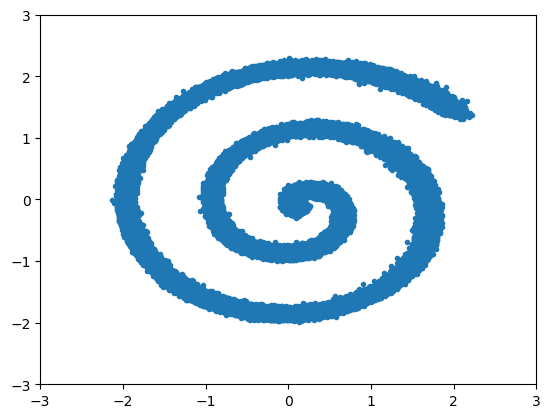

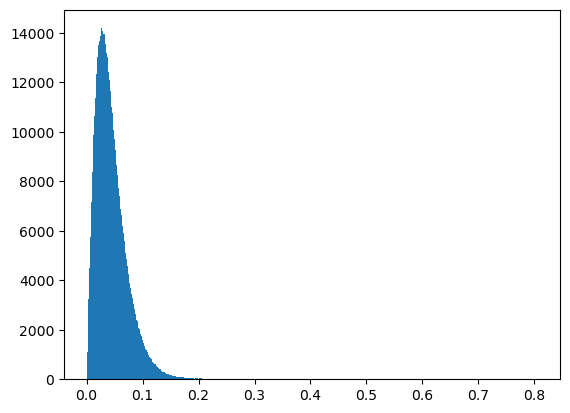

0.044596437
No saved model weights found or Training=True.
training ...
train data length:  1024  last_loss:  0.20896633015945554
training ...
train data length:  1024  last_loss:  0.17074700130615383


Sampling: 100%|██████████| 1000/1000 [05:56<00:00,  2.80iteration/s]


KLD:  0.182131024986536
Train data size: 1024


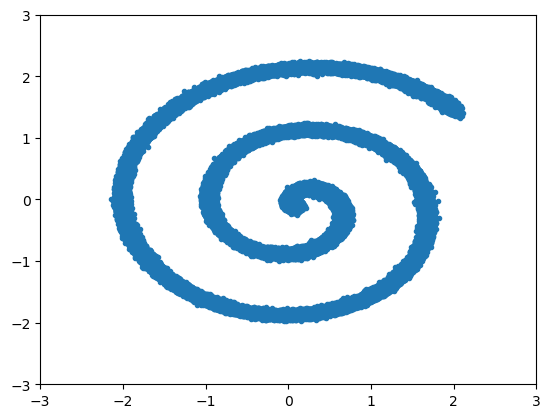

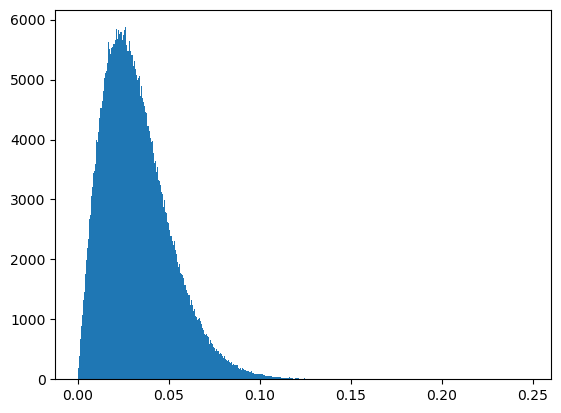

0.032613758
No saved model weights found or Training=True.
training ...
train data length:  2048  last_loss:  0.21196184383006766
training ...
train data length:  2048  last_loss:  0.15086036233697087


Sampling: 100%|██████████| 1000/1000 [05:59<00:00,  2.78iteration/s]


KLD:  0.06985574830942475
Train data size: 2048


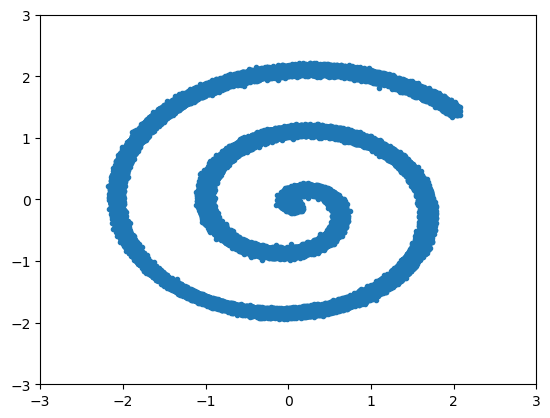

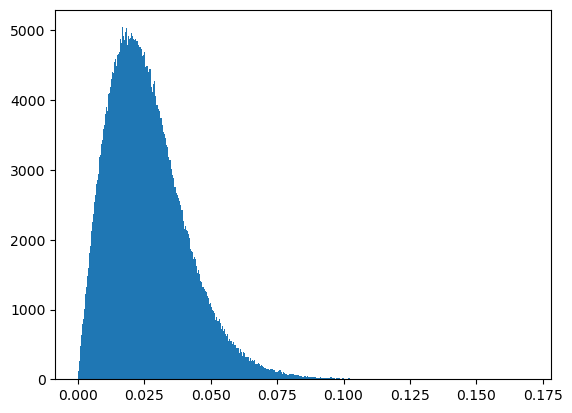

0.0263976
No saved model weights found or Training=True.
training ...
train data length:  4096  last_loss:  0.19421194065944292
training ...
train data length:  4096  last_loss:  0.14484843116952106


Sampling: 100%|██████████| 1000/1000 [05:58<00:00,  2.79iteration/s]


KLD:  0.05652009279764339
Train data size: 4096


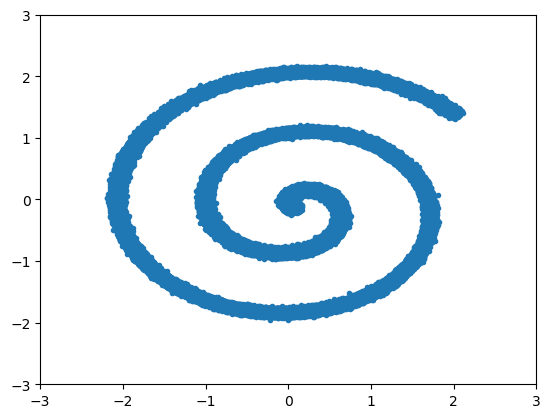

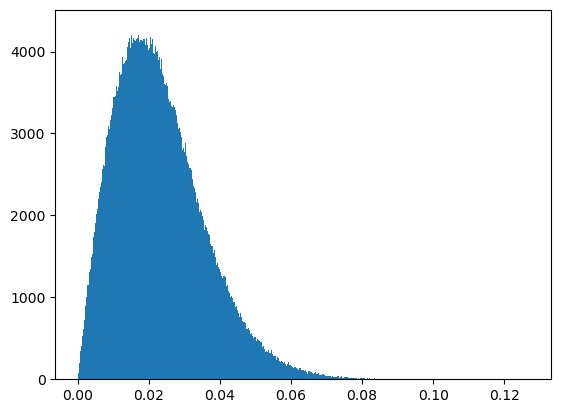

0.02313083
No saved model weights found or Training=True.
training ...
train data length:  8192  last_loss:  0.17167144812992774
training ...
train data length:  8192  last_loss:  0.1571247622850933


Sampling: 100%|██████████| 1000/1000 [05:56<00:00,  2.80iteration/s]


KLD:  0.009040404853896818
Train data size: 8192


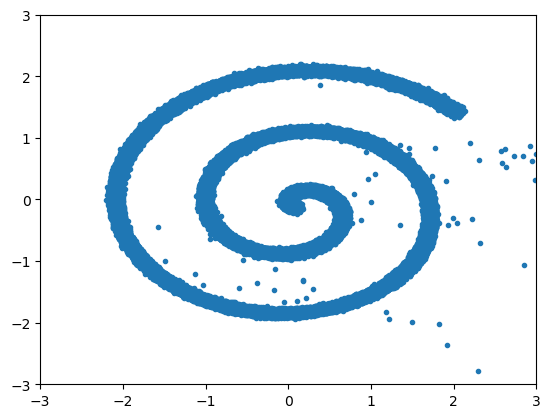

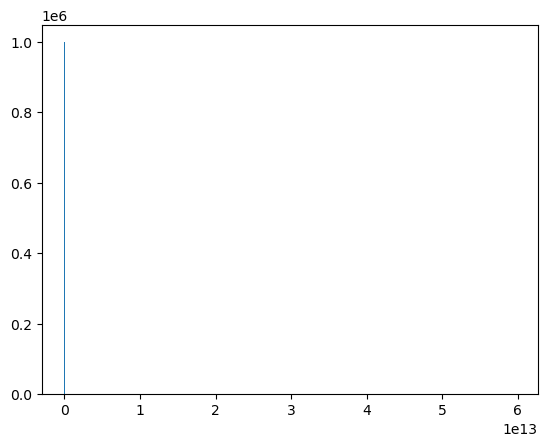

3188487400.0


In [4]:
seed_everything(0)
# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 0.5 # for SDE noise [VP]
cond_scale =1
rescaled_phi = 0

device='cuda'
train_len_vals = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
sample_size = int(1E6)
orig_sample, orig_labels = data_gen(sample_size)
data_mu = torch.mean(orig_sample, dim=0).unsqueeze(0)
data_std = torch.std(orig_sample, dim=0).unsqueeze(0)
orig_sample = (orig_sample - data_mu) / data_std
last_loss_values = []
fid_values = []
avg_nll_values = []
KLD_arr = []
H_gen_arr = []
H_true_arr = []

Training =True

for train_data_length in train_len_vals:
    seed_everything(0)
    train_data, train_labels = data_gen(train_data_length)
    data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
    data_std = torch.std(train_data, dim=0).unsqueeze(0)
    train_data = (train_data - data_mu) / data_std
    #train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
    train_set = [
        (train_data[i], train_labels[i]) for i in range(train_data_length)
    ]
    generator = torch.Generator().manual_seed(0)
    train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size
    )

    vp = uncon_VP_1D(beta_min, beta_max)

    model = CtrlCondResNet(2, 2, 1, conv_channels=128, model_channels=128, channel_mult=[1,1,1,1,1,1], 
                    channel_mult_emb=1, num_blocks=2, dropout=0, 
                    emb_type="sinusoidal", channel_mult_time=1, 
                    channel_mult_cond=1)

    file_path = f'mdl_weights/ctrl_train_len_{train_data_length}.pth'

    if os.path.exists(file_path) and not Training:
        model.load_state_dict(torch.load(file_path))
        print("Model weights loaded successfully, computing last epoch loss.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c)
                
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                num_items += x.shape[0]
                avg_loss += loss.item() * x.shape[0]
    else:
        print("No saved model weights found or Training=True.")
        # for training of the uncon model, lock the control net
        for name, param in model.named_parameters():
            if 'ctrl' in name:
                param.requires_grad = False

        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c, controlnet=False)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

        # for training of the control net, lock the uncon model
        for name, param in model.named_parameters():
            if 'ctrl' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses_cond(model, vp, x, c, controlnet=True)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
                loss_v.append(loss.item())
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            #if epoch % output_step == 0 or epoch == num_epochs - 1:
        torch.save(model.state_dict(), 'mdl_weights/ctrl_train_len'+'_'+str(train_data_length)+'.pth')
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

    model.eval()
    last_loss = avg_loss / num_items
    vp_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
    #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
    test_cond = torch.rand(sample_size, device=device)*10-5
    with torch.no_grad():
        samples, _ = vp_sampler(model, vp, (sample_size, 2),  device, c=test_cond,
                                controlnet=True)
    #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
    samples = samples.detach().cpu().numpy()
    fid = fid_metric(samples, orig_sample.detach().cpu().numpy())
    inverse_scaler = 1 # dummy param
    #likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
    #nll = likelihood_fn(model, orig_sample.to(device))[0]
    #avg_nll = np.mean(nll.detach().cpu().numpy())
    '''
    nll_total = 0
    process_batch_size = 100000
    for i in range(0, orig_sample.size(0), process_batch_size):
        batch = orig_sample[i:i + process_batch_size].to(device)  
        batch_nll = likelihood_fn(model, batch)[0]  
        nll_total += batch_nll.sum().item()  
    # Calculate the average NLL
    avg_nll = nll_total / orig_sample.size(0)
    '''
    
    last_loss_values.append(last_loss)
    fid_values.append(fid)
    #avg_nll_values.append(avg_nll)
    kld, H_gen, H_true = get_KLD(samp1=samples, dat=orig_sample.detach().cpu().numpy())
    KLD_arr.append(kld)
    H_gen_arr.append(H_gen)
    H_true_arr.append(H_true)

    print('Train data size:', train_data_length)
    plt.plot(samples[:,0], samples[:,1], ".")
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.show()
    true_pos = get_pos_from_rad(test_cond)
    avg_err = np.mean(np.abs(samples-true_pos), axis=1)
    plt.hist(avg_err, bins=1000)
    plt.show()
    print(np.mean(avg_err))

In [5]:
import pandas as pd

results_df = pd.DataFrame({
    'data_len': train_len_vals,
    'beta_max': np.repeat(beta_max, len(train_len_vals)),
    'last_loss': last_loss_values[-len(train_len_vals):],
    'fid': fid_values[-len(train_len_vals):],
    #'avg_nll': avg_nll_values[-len(train_len_vals):],
    'KLD': KLD_arr[-len(train_len_vals):],
    'H Gen': H_gen_arr[-len(train_len_vals):],
    'H True': H_true_arr[-len(train_len_vals):]
})

print(results_df)

   data_len  beta_max  last_loss           fid       KLD     H Gen    H True
0       128       0.5   0.411907  1.885428e-02  0.963364  1.651155  1.218089
1       256       0.5   0.280368  5.122234e-03  0.729937  1.261321  1.218089
2       512       0.5   0.148181  3.085438e-03  0.413741  1.254964  1.218089
3      1024       0.5   0.170747  1.572599e-03  0.182131  1.200434  1.218089
4      2048       0.5   0.150860  6.778202e-04  0.069856  1.221787  1.218089
5      4096       0.5   0.144848  2.754664e-04  0.056520  1.214010  1.218089
6      8192       0.5   0.157125  1.253540e+23  0.009040  1.212330  1.218089
